# Building Energy Consumption Modeling

In [36]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import pickle

In [109]:
file_name = 'Weather_and_Energy_dataset.csv' # this file has been saved from the last notebook
data_path = os.getcwd()

In [38]:
df = pd.read_csv(data_path + file_name)
print(df.shape)

(25383, 7)


In [39]:
df.columns 

Index(['temp', 'humidity', 'wind_speed', 'pressure', 'dew_point', 'date',
       'hvac_S'],
      dtype='object')

In [57]:
# Find the standard deviation and the range of data
df['hvac_S'].describe()

count    24997.000000
mean        19.662879
std         12.934880
min          0.000000
25%         10.049500
50%         20.905000
75%         26.660000
max         75.200000
Name: hvac_S, dtype: float64

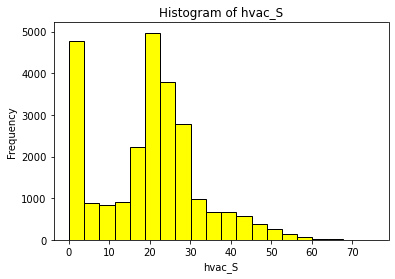

In [56]:
# Plot a histogram to view the dispersion of the data
plt.hist(df['hvac_S'], bins=20, color='yellow', edgecolor='black')
plt.title('Histogram of hvac_S')
plt.xlabel('hvac_S')
plt.ylabel('Frequency')
plt.show()

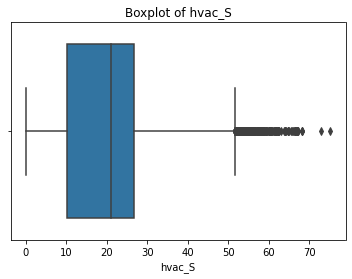

In [58]:
# Create a boxplot to identify potential outliers and high-energy consumption days
sns.boxplot(x=df['hvac_S'])
plt.title('Boxplot of hvac_S')
plt.show()

In [63]:
percentiles = [70, 80, 85, 90, 95, 99]
for p in percentiles:
    threshold = df['hvac_S'].quantile(p / 100)
    print(f'{p}th percentile threshold: {threshold}')

70th percentile threshold: 25.41666667
80th percentile threshold: 28.075
85th percentile threshold: 30.17936842
90th percentile threshold: 35.565345620000016
95th percentile threshold: 42.76386996999998
99th percentile threshold: 52.83142857280006


Convert Target Variable

0    70.460544
1    29.539456
Name: high_energy_day, dtype: float64


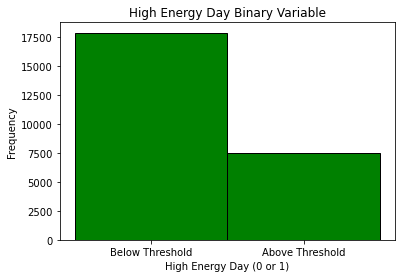

In [82]:
# Set the threshold based on the 80th percentile
threshold_percentile = df['hvac_S'].quantile(0.70)

# Create the binary variable
df['high_energy_day'] = (df['hvac_S'] > threshold_percentile).astype(int)

# Display the counts of the new binary variable
print(df['high_energy_day'].value_counts(normalize=True) * 100)

# Optionally, you can plot a histogram of the new binary variable
plt.hist(df['high_energy_day'], bins=[-0.5, 0.5, 1.5], color='green', edgecolor='black')
plt.title('High Energy Day Binary Variable')
plt.xlabel('High Energy Day (0 or 1)')
plt.ylabel('Frequency')
plt.xticks([0, 1], ['Below Threshold', 'Above Threshold'])
plt.show()


In [104]:
# Scale and select relevant features
scaler = StandardScaler()
numerical_cols = ['temp', 'humidity', 'wind_speed', 'pressure', ] #'dew_point'
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

In [105]:
# Split dataset
X = df.drop(['hvac_S', 'high_energy_day', 'date', 'dew_point'], axis=1)  
y = df['high_energy_day']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [102]:
# Adding a constant term to the features matrix for statsmodels
X_train = sm.add_constant(X_train)

# Building and Training the Model using statsmodels
model = sm.Logit(y_train, X_train)
result = model.fit()

Optimization terminated successfully.
         Current function value: 0.500989
         Iterations 6


In [103]:
# Display model summary to see significance of individual features
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        high_energy_day   No. Observations:                20306
Model:                          Logit   Df Residuals:                    20301
Method:                           MLE   Df Model:                            4
Date:                Mon, 05 Feb 2024   Pseudo R-squ.:                  0.1749
Time:                        21:07:57   Log-Likelihood:                -10173.
converged:                       True   LL-Null:                       -12330.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0410      0.018    -57.875      0.000      -1.076      -1.006
temp           1.1141      0.026     43.162      0.000       1.064       1.165
humidity      -0.0666      0.022     -3.080      0.002      -0.109      -0.024
wind_speed    -0.1306      0.018     -7.098      0.000      -0.167      -0.095
pressure       0.0508      0.021      2.401      0.016       0.009       0.092
==============================================================================
"""

In [106]:
# Initialize and train logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [107]:
# Predictions on the test set
y_pred = model.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

Accuracy: 0.7825487492613749
              precision    recall  f1-score   support

           0       0.79      0.93      0.86      3584
           1       0.72      0.42      0.53      1493

    accuracy                           0.78      5077
   macro avg       0.76      0.68      0.70      5077
weighted avg       0.77      0.78      0.76      5077



In [111]:
# Save the trained model and other necessary objects
model_filename = 'logistic_regression_model.pkl'
with open(data_path + model_filename, 'wb') as file:
    pickle.dump({
        'model': model,
        'X_train_columns': X_train.columns,
        'threshold_percentile': threshold_percentile
    }, file)

print(f'Model and related objects saved to {model_filename}')

Model and related objects saved to logistic_regression_model.pkl


### Energy Consumption TimeSeries Prediction

We will use a Recurrent Nueral Network (RNN) because the sequence of events is important for our time series data.

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from math import sqrt

In [ ]:
# Convert date feature 
df = df.copy()
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)  

# Resample to hourly intervals
df = df.resample('H').mean()

In [87]:
# Drop binary feature from previous section
df.drop(columns=['hvac_S_binary'],inplace=True)

In [ ]:
# Impute missing values using forward fill
df = df.fillna(method='ffill')

In [ ]:
energy_df = df[['hvac_S']]

In [ ]:
energy_df.plot(figsize=(12,6))

In [ ]:
results = seasonal_decompose(energy_df['hvac_S'])
results.plot();

In [ ]:
len(energy_df)

In [ ]:
# Calculate the number of data points for each set
total_data_points = len(df)
train_size = int(total_data_points * 0.8)
validation_size = int(total_data_points * 0.1)

# Split the data
train_data = energy_df.iloc[:train_size]
validation_data = energy_df.iloc[train_size: train_size + validation_size]
test_data = energy_df.iloc[train_size + validation_size:]

# Print the sizes of each set
print(f"Train set size: {len(train_data)} data points")
print(f"Validation set size: {len(validation_data)} data points")
print(f"Test set size: {len(test_data)} data points")

In [ ]:
# Scale the data for modeling
scaler = MinMaxScaler()

In [ ]:
scaler.fit(train_data)
scaled_train = scaler.transform(train_data)
scaled_val = scaler.transform(validation_data)
scaled_test = scaler.transform(test_data)

In [ ]:
len(df.columns)

In [ ]:
# Define generator
n_input = 12 # how many hours to train the data
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=10)

In [ ]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n{y}')

In [ ]:
X.shape

In [ ]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(100, activation='relu',input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.summary()

In [ ]:
# Train the model
model.fit(generator, epochs=10)

In [ ]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch) 

In [ ]:
# Take the last 12 training values to make a prediction on the next set
last_train_batch = scaled_train[-12:]
last_train_batch = last_train_batch.reshape((1,n_input,n_features))

In [ ]:
# Make predictions
model.predict(last_train_batch)

In [ ]:
scaled_test[0]

In [ ]:
# Compare the test set to test predictions
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1,n_input,n_features))

for i in range(len(test_data)):
    
    current_pred = model.predict(current_batch)[0]
    
    test_predictions.append(current_pred)
    
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [ ]:
# Plot both predictions 
true_predictions = scaler.inverse_transform(test_predictions)

test_data['Predictions'] = true_predictions

test_data.plot(figsize=(12,6))

In [ ]:
# Model performance
rmse=sqrt(mean_squared_error(test_data['hvac_S'],test_data['Predictions']))
print(rmse)